<h3>Import packages</h3>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Configure TensorFlow to use GPU
tf.config.list_physical_devices('GPU') 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
#Set GPU memory limit so my GPU doesn't crash
if gpus:
    try:
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


In [3]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('Models/VGG16/VGG16_covid_classification_finetuned_98p.h5')
# model = tf.keras.models.load_model('Models/VGG16/VGG16_covid_classification_95.h5')

# Show the model architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 2,360,321
Non-trainable params: 12,354,880
_________________________________________

<h3>Process data</h3>

In [4]:
test_path = 'dataset_7'

#Preprocess test data
test = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
.flow_from_directory(directory=test_path, target_size=(224,224), class_mode = 'binary', batch_size=32, shuffle=False)

Found 430 images belonging to 2 classes.


<h3>Evaluate Test data</h3>

In [5]:
testLoss, testAcc = model.evaluate(test, verbose = 2)
print('''
Test Loss: {}
Test Accuracy: {}
'''.format(testLoss, testAcc))

14/14 - 10s - loss: 0.1981 - binary_accuracy: 0.9372 - 10s/epoch - 716ms/step

Test Loss: 0.19807502627372742
Test Accuracy: 0.9372093081474304



<h3>Classification report</h3>

In [6]:
predictions = model.predict(test, verbose=0)
lst = (predictions > 0.5).astype(int)

print(classification_report(test.classes, lst, target_names = test.class_indices))

              precision    recall  f1-score   support

       covid       0.96      0.89      0.92       180
      normal       0.92      0.97      0.95       250

    accuracy                           0.94       430
   macro avg       0.94      0.93      0.93       430
weighted avg       0.94      0.94      0.94       430



<h3>Confusion matrix</h3>

[[160  20]
 [  7 243]]


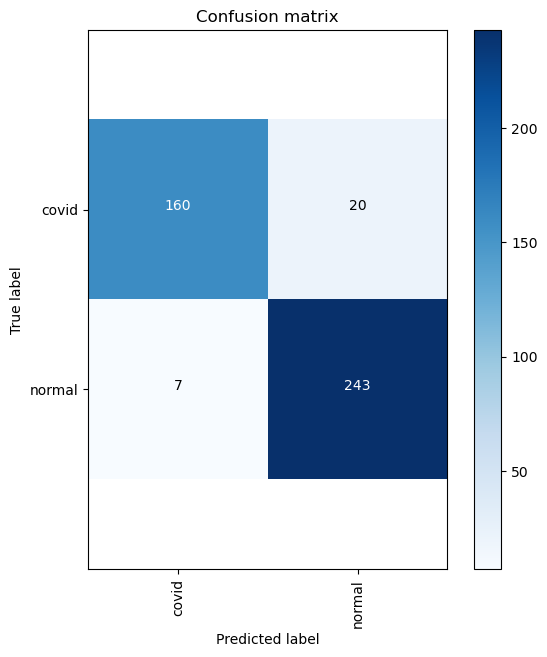

In [7]:
result = confusion_matrix(test.classes, lst)
print(result)

def plot_confusion_matrix(result, classes, cmap=plt.cm.Blues):
    plt.subplots(figsize=(7, 7))
    plt.imshow(result, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   

    thresh = result.max() / 2.
    for i, j in itertools.product(range(result.shape[0]), range(result.shape[1])):
        plt.text(j, i, result[i, j],
            horizontalalignment="center",
            color = "white" if result[i, j] > thresh else "black")
        
    #current matplotlib version will cut off top and bottom of the matrix, 
    #hence the manual workaround - remove if matplotlib version does not cut off
    b, t = plt.ylim() # discover bottom and top values
    b += 0.5 # Add 0.5 to bottom
    t -= 0.5 # Subtract 0.5 from top
    plt.ylim(b, t) # update ylim(bottom, top) values
    plt.show()
    
plot_confusion_matrix(result, list(test.class_indices.keys()))